In [1]:
import random
import numpy as np
import torch
from transformers import set_seed

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [2]:
import os
import torch
import transformers
import numpy as np
import matplotlib.pyplot as plt

HF_TOKEN = os.getenv("HF_TOKEN")

# model_name = "meta-llama/Llama-3.2-1B"
# model_name = "meta-llama/Llama-3.2-1B-Instruct"
# model_name = "meta-llama/Llama-3.2-3B"
model_name = "meta-llama/Llama-3.2-3B-Instruct"
# model_name = "google/gemma-2-2b"
# model_name = "google/gemma-2-2b-it"
# model_name = "google/gemma-2-9b"
# model_name = "google/gemma-2-9b-it"

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    output_hidden_states=True,  # Enable hidden states
    token=HF_TOKEN,
)
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_name,
    token=HF_TOKEN,
)

print(model, model.config)


c:\Users\sewoo\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


Some parameters are on the meta device because they were offloaded to the cpu.


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
      )
    )
    (norm

In [3]:
from src.util.json_io import *

train_qnas = load_jsonlines(f'data/gsm8k/train.jsonl')
test_qnas = load_jsonlines(f'data/gsm8k/test.jsonl')
len(train_qnas), len(test_qnas)

(7473, 1319)

In [4]:
import random; rseed = 42; random.seed(rseed)

nshot_prompt = f""
for top_logit_indices in random.sample(range(len(train_qnas)), 8):
    nshot_prompt += f"Question: {train_qnas[top_logit_indices]['question']}\nAnswer: {train_qnas[top_logit_indices]['answer']}\n\n"

print(nshot_prompt)

Question: For every 12 cans you recycle, you receive $0.50, and for every 5 kilograms of newspapers, you receive $1.50. If your family collected 144 cans and 20 kilograms of newspapers, how much money would you receive?
Answer: There are 144/12 = <<144/12=12>>12 sets of 12 cans that the family collected.
So, the family would receive $0.50 x 12 = $<<0.50*12=6>>6 for the cans.
There are 20/5 = <<20/5=4>>4 sets of 5 kilograms of newspapers that the family collected.
So, the family would receive $1.50 x 4 = $<<1.50*4=6>>6 for the newspapers.
Therefore, the family would receive a total of $6 + $6 = $<<6+6=12>>12.
#### 12

Question: Betty picked 16 strawberries. Matthew picked 20 more strawberries than Betty and twice as many as Natalie. They used their strawberries to make jam. One jar of jam used 7 strawberries and they sold each jar at $4. How much money were they able to make from the strawberries they picked?
Answer: Matthew picked 16 + 20 = <<16+20=36>>36 strawberries.
Natalie picked 3

In [5]:
def question_to_prompt(question):
    return f"{nshot_prompt}Question: {question} Let's think step by step.\nAnswer: "

sample_i = 8
print(question_to_prompt(test_qnas[sample_i]['question']))

from src.util.gsm8k_helper import *
print('Answer:', extract_num_from_ans(test_qnas[sample_i]['answer']))
print('Answer in integer:', extract_num_from_ans(test_qnas[sample_i]['answer']))

Question: For every 12 cans you recycle, you receive $0.50, and for every 5 kilograms of newspapers, you receive $1.50. If your family collected 144 cans and 20 kilograms of newspapers, how much money would you receive?
Answer: There are 144/12 = <<144/12=12>>12 sets of 12 cans that the family collected.
So, the family would receive $0.50 x 12 = $<<0.50*12=6>>6 for the cans.
There are 20/5 = <<20/5=4>>4 sets of 5 kilograms of newspapers that the family collected.
So, the family would receive $1.50 x 4 = $<<1.50*4=6>>6 for the newspapers.
Therefore, the family would receive a total of $6 + $6 = $<<6+6=12>>12.
#### 12

Question: Betty picked 16 strawberries. Matthew picked 20 more strawberries than Betty and twice as many as Natalie. They used their strawberries to make jam. One jar of jam used 7 strawberries and they sold each jar at $4. How much money were they able to make from the strawberries they picked?
Answer: Matthew picked 16 + 20 = <<16+20=36>>36 strawberries.
Natalie picked 3

In [6]:
def generate_answer(input_text, top_k=1):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            max_length=input_ids.shape[1] + 512,
            do_sample=True, top_k=top_k,
            eos_token_id=tokenizer.encode(text='\n\n', add_special_tokens=False)[0],
            pad_token_id=tokenizer.eos_token_id,
            return_dict_in_generate=True, 
            output_logits=True, 
            output_hidden_states=True,
        )

    output_text = tokenizer.decode(outputs.sequences[0])
    generated_answer = output_text.split('Answer: ')[-1].split('\n\n')[0]
    generated_len = len(outputs.logits)

    k = 3
    topk_indices = torch.zeros((generated_len, k), dtype=torch.long)
    topk_logits = torch.zeros((generated_len, k))
    topk_probabilities = torch.zeros((generated_len, k))

    # Iterate over each sequence position to find the top-3 indices and their logits and probabilities
    for seq_idx, logits_tensor in enumerate(outputs.logits): # outputs.logits: (seq_length, batch_size, vocab_size)
        logits = logits_tensor[0]  # score_tensor.shape: (batch_size, vocab_size)
        
        top_logit_values, top_logit_indices = torch.topk(logits, k=3)
        
        topk_indices[seq_idx] = top_logit_indices  # Indices of the top-3 tokens
        topk_logits[seq_idx] = top_logit_values  # Logits of the top-3 tokens
        topk_probabilities[seq_idx] = torch.nn.functional.softmax(logits, dim=-1)[top_logit_indices]  # Probabilities of the top-3 tokens

    return {
        'generated_answer': generated_answer,
        'generated_indices': outputs.sequences[0][input_ids.shape[1]:],
        'generated_tokens': [tokenizer.decode(i) for i in outputs.sequences[0][input_ids.shape[1]:]],
        'generated_token_len': len(outputs.sequences[0][input_ids.shape[1]:]),
        'topk_indices': topk_indices,
        'topk_tokens': [[tokenizer.decode(i) for i in row] for row in topk_indices],
        'topk_logits': topk_logits,
        'topk_probabilities': topk_probabilities,
        'vocab_size': outputs.logits[0].shape[-1],
    }

In [7]:
generate_answer(question_to_prompt(test_qnas[sample_i]))

c:\Users\sewoo\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\llama\modeling_llama.py:655: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


{'generated_answer': '180 miles because he was 180 miles from home when he turned around.\n#### 180',
 'generated_indices': tensor([5245, 8931, 1606,  568,  574,  220, 5245, 8931,  505, 2162,  994,  568,
         6656, 2212,  627,  827,  220, 5245,  271], device='cuda:0'),
 'generated_tokens': ['180',
  ' miles',
  ' because',
  ' he',
  ' was',
  ' ',
  '180',
  ' miles',
  ' from',
  ' home',
  ' when',
  ' he',
  ' turned',
  ' around',
  '.\n',
  '####',
  ' ',
  '180',
  '\n\n'],
 'generated_token_len': 19,
 'topk_indices': tensor([[  5245,     18,   3842],
         [  8931,    198,    374],
         [  1606,    374,    505],
         [   568,    994,   3842],
         [   574,  23980,  31796],
         [   220,  10043,  21646],
         [  5245,     18,   1399],
         [  8931,    994,     14],
         [   505,   3201,    994],
         [  2162,    813,    279],
         [   994,  15453,   1306],
         [   568,   3842,    279],
         [  6656,   3940,   1176],
         [ 

In [8]:
print("* Sample Question:", test_qnas[sample_i]['question'])
print("* Expected Answer:", test_qnas[sample_i]['answer'])

* Sample Question: John drives for 3 hours at a speed of 60 mph and then turns around because he realizes he forgot something very important at home.  He tries to get home in 4 hours but spends the first 2 hours in standstill traffic.  He spends the next half-hour driving at a speed of 30mph, before being able to drive the remaining time of the 4 hours going at 80 mph.  How far is he from home at the end of those 4 hours?
* Expected Answer: When he turned around he was 3*60=<<3*60=180>>180 miles from home
He was only able to drive 4-2=<<4-2=2>>2 hours in the first four hours
In half an hour he goes 30*.5=<<30*.5=15>>15 miles
He then drives another 2-.5=<<2-.5=1.5>>1.5 hours
In that time he goes 80*1.5=<<80*1.5=120>>120 miles
So he drove 120+15=<<120+15=135>>135 miles
So he is 180-135=<<180-135=45>>45 miles away from home
#### 45


In [9]:
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime
import os

def visualize_topk_plotly(ans_data, save_html=False, show_text=True):
    data = []
    for i in range(ans_data['generated_token_len']):
        row = {
            'Token Position': i + 1,
            'Generated Token': ans_data['generated_tokens'][i],
            'Top-1 Token': ans_data['topk_tokens'][i][0],
            'Top-1 Probability': ans_data['topk_probabilities'][i][0].item(),
            'Top-2 Token': ans_data['topk_tokens'][i][1],
            'Top-2 Probability': ans_data['topk_probabilities'][i][1].item(),
            'Top-3 Token': ans_data['topk_tokens'][i][2],
            'Top-3 Probability': ans_data['topk_probabilities'][i][2].item(),
        }
        data.append(row)
    df = pd.DataFrame(data)

    print(''.join(df['Generated Token'].values))
    
    fig = go.Figure()

    for rank, (prob_column, token_column) in enumerate(
        zip(["Top-1 Probability", "Top-2 Probability", "Top-3 Probability"], 
            ["Top-1 Token", "Top-2 Token", "Top-3 Token"]), start=1):
        
        marker_sizes = [
            12 if df.iloc[i]['Generated Token'] == df.iloc[i][token_column] else 6
            for i in range(len(df))
        ]
        
        fig.add_trace(go.Scatter(
            x=df['Token Position'],
            y=df[prob_column],
            mode='lines+markers' + ('+text' if show_text else ''),
            name=f'Top-{rank} Probability',
            text=df[token_column] if show_text else None,
            textposition="top center",
            marker=dict(size=marker_sizes)
        ))
    
    fig.update_layout(
        title="Top-3 Token Probabilities at Each Generation Step",
        xaxis_title="Token Position",
        yaxis_title="Probability",
        legend=dict(
            x=1.05,
            y=1,
            title="Probabilities",
            orientation="v"
        ),
        autosize=True,
        margin=dict(l=50, r=50, t=50, b=50)
    )
    
    fig.show()
    
    if save_html:
        os.makedirs("outputs", exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        html_path = f"outputs/topk_plot_{timestamp}.html"
        
        fig.write_html(html_path)
        print(f"Plot saved as HTML at: {html_path}")

In [10]:
set_seed(42)

ans_data = generate_answer(question_to_prompt(test_qnas[sample_i]))

visualize_topk_plotly(
    ans_data, 
    save_html=True,
)

180 miles because he was 180 miles from home when he turned around.
#### 180




Plot saved as HTML at: outputs/topk_plot_20241204_135204.html


In [11]:
set_seed(12345)

ans_data = generate_answer(
    question_to_prompt(test_qnas[sample_i]), 
    top_k=3,
)
visualize_topk_plotly(
    ans_data, 
    save_html=True,
)

180 miles because John drove for 3 hours at 60 mph, which is 3*60=<<3*60=180>>180 miles.
He was only able to drive 2 hours in the first four hours, which is 2*60=<<2*60=120>>120 miles.
In half an hour he goes 30*.5=<<30*.5=15>>15 miles.
He then drives another 1.5 hours, which is 1.5*80=<<1.5*80=120>>120 miles.
So he drove a total of 120+15=135 miles.
So he is 180-135=<<180-135=45>>45 miles away from home.
#### 45




Plot saved as HTML at: outputs/topk_plot_20241204_135349.html


In [12]:
top1_probs = ans_data['topk_probabilities'][:, 0].numpy()
top2_probs = ans_data['topk_probabilities'][:, 1].numpy()
top1_logits = ans_data['topk_logits'][:, 0].numpy()
top2_logits = ans_data['topk_logits'][:, 1].numpy()

features = {
    'generated_length': ans_data['generated_token_len'],
    'sum_logits_top1_top2_diff': (top1_logits - top2_logits).sum(),
    'avg_logits_top1_top2_diff': (top1_logits - top2_logits).mean(),
    'min_logits_top1_top2_diff': (top1_logits - top2_logits).min(),
    'sum_logits_top1': top1_logits.sum(),
    'avg_logits_top1': top1_logits.mean(),
    'min_logits_top1': top1_logits.min(),
    'sum_prob_top1_top2_diff': (top1_probs - top2_probs).sum(),
    'avg_prob_top1_top2_diff': (top1_probs - top2_probs).mean(),
    'min_prob_top1_top2_diff': (top1_probs - top2_probs).min(),
    'sum_prob_top1': top1_probs.sum(),
    'avg_prob_top1': top1_probs.mean(),
    'min_prob_top1': top1_probs.min(),
}

features

{'generated_length': 154,
 'sum_logits_top1_top2_diff': 872.7656,
 'avg_logits_top1_top2_diff': 5.6673093,
 'min_logits_top1_top2_diff': 0.015625,
 'sum_logits_top1': 3767.8438,
 'avg_logits_top1': 24.466518,
 'min_logits_top1': 16.3125,
 'sum_prob_top1_top2_diff': 124.82466,
 'avg_prob_top1_top2_diff': 0.81054974,
 'min_prob_top1_top2_diff': 0.0037948787,
 'sum_prob_top1': 134.74902,
 'avg_prob_top1': 0.8749937,
 'min_prob_top1': 0.22887741}

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
import os

def visualize_topk_matplotlib(ans_data, save_pdf=False, show_text=True):
    # Prepare data
    data = []
    for i in range(ans_data['generated_token_len']):
        row = {
            'Token Position': i + 1,
            'Generated Token': ans_data['generated_tokens'][i],
            'Top-1 Token': ans_data['topk_tokens'][i][0],
            'Top-1 Probability': ans_data['topk_probabilities'][i][0].item(),
            'Top-2 Token': ans_data['topk_tokens'][i][1],
            'Top-2 Probability': ans_data['topk_probabilities'][i][1].item(),
        }
        data.append(row)
    df = pd.DataFrame(data)

    # Print the generated sequence
    print(''.join(df['Generated Token'].values))

    # Plotting
    plt.figure(figsize=(20, 5))

    for rank, (prob_column, token_column) in enumerate(
        [("Top-1 Probability", "Top-1 Token"), 
         ("Top-2 Probability", "Top-2 Token")], start=1):
        
        plt.plot(
            df['Token Position'],
            df[prob_column],
            marker='o',
            markersize=5,
            label=f'Top-{rank} Probability'
        )
        
        if show_text:
            for i, txt in enumerate(df[token_column]):
                offset = -0.03 if rank == 2 else 0.02  # Adjust text position: below for Top-2
                plt.text(
                    df['Token Position'][i],
                    df[prob_column][i] + offset,
                    txt,
                    fontsize=8,
                    ha='center',
                    va='top' if rank == 2 else 'bottom'
                )

    # Plot styling
    # plt.title("Top-2 Token Probabilities at Each Generation Step")
    plt.xlabel("Token Position")
    plt.ylabel("Probability")
    # plt.xticks(ticks=df['Token Position'], labels=df['Token Position'])  # Ensure integer ticks
    # plt.legend(loc="upper left")
    # plt.grid(True)
    plt.tight_layout()

    # Save plot as PDF if requested
    if save_pdf:
        os.makedirs("outputs", exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        pdf_path = f"outputs/top2_plot_{timestamp}.pdf"
        with PdfPages(pdf_path) as pdf:
            pdf.savefig()  # Save the current figure to the PDF
        print(f"Plot saved as PDF at: {pdf_path}")

    # Show plot
    plt.show()


180 miles because he was 180 miles from home when he turned around.
#### 180


Plot saved as PDF at: outputs/top2_plot_20241204_141034.pdf


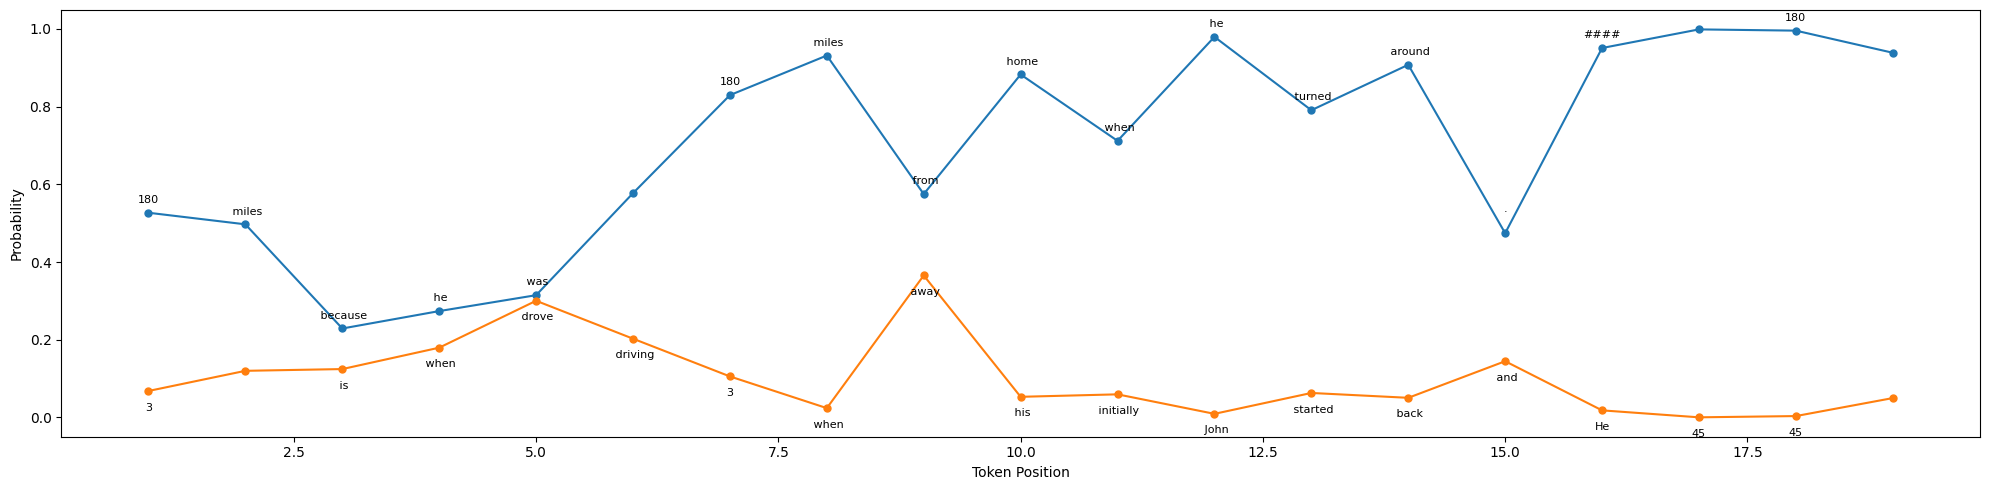

In [33]:
set_seed(42)

ans_data = generate_answer(question_to_prompt(test_qnas[sample_i]))

visualize_topk_matplotlib(
    ans_data, 
    save_pdf=True,
)

180 miles because when he turned around, he was 3*60=<<3*60=180>>180 miles from home.
He was only able to drive 4-2=<<4-2=2>>2 hours in the first four hours.
In half an hour he goes 30*.5=<<30*.5=15>>15 miles.
He then drives another 2-.5=<<2-.5=1.5>>1.5 hours
In that time he goes 80*1.5=<<80*1.5=120>>120 miles
So he drove 120+15=<<120+15=135>>135 miles
So he is 180-135=<<180-135=45>>45 miles away from home
#### 45


Plot saved as PDF at: outputs/top2_plot_20241204_141439.pdf


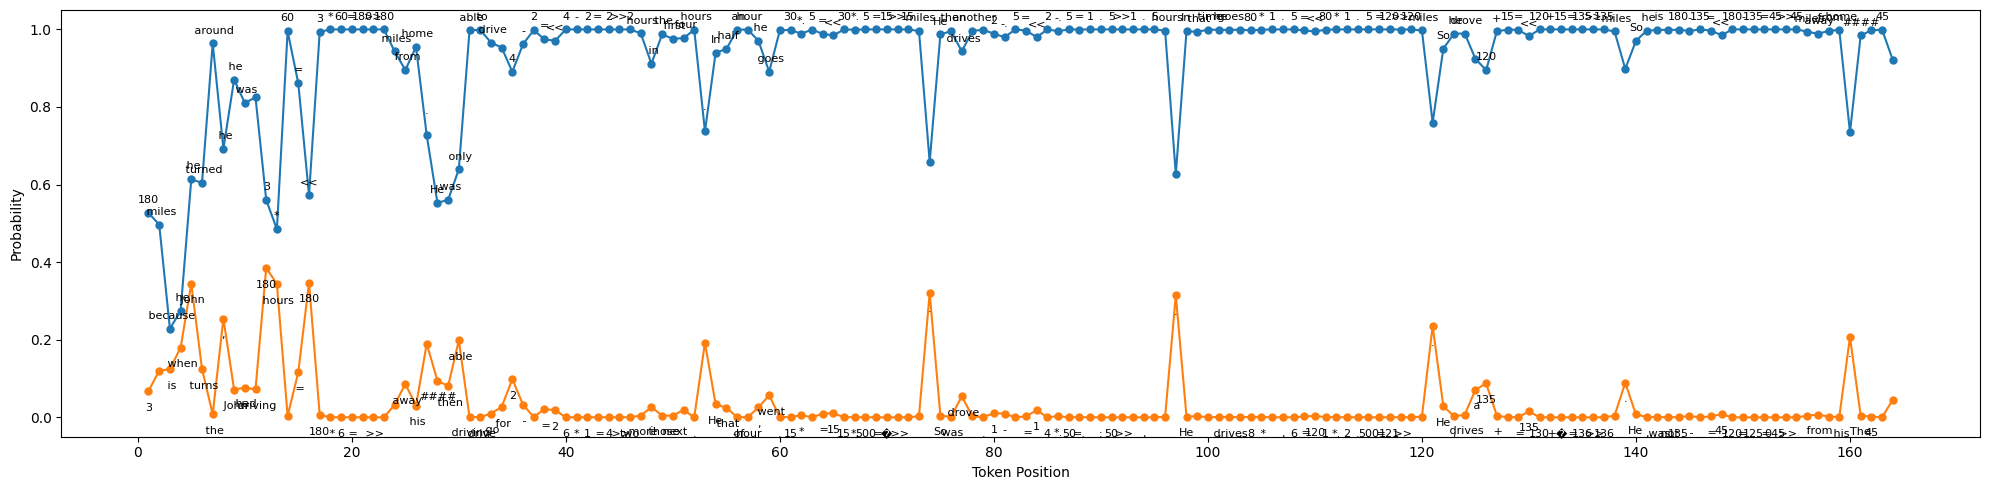

In [34]:
set_seed(12345)

ans_data = generate_answer(
    question_to_prompt(test_qnas[sample_i]), 
    top_k=2,
)
visualize_topk_matplotlib(
    ans_data, 
    save_pdf=True,
)